In [1]:
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16384, shuffle=True)

test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

In [3]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

50000
10000
10000


In [4]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
			torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
			torch.nn.ReLU(),
			torch.nn.MaxPool2d(kernel_size=2),
			torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
			torch.nn.ReLU(),
			torch.nn.MaxPool2d(kernel_size=2),
			torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
			torch.nn.ReLU(),
			torch.nn.MaxPool2d(kernel_size=2)
		)

        self.decoder = torch.nn.Sequential(
			torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
			torch.nn.ReLU(),
			torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
			torch.nn.ReLU(),
			torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2),
			torch.nn.ReLU()
		)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
# ovo sam koristio kako bih nastimao dobre dimenzije izlaza
# rekonstruirana slika treba biti istih dimenzija kao i ulaz, pa sam trebao namjestiti dobar kernel_size, padding, stride...
# zakomentirao sam tu liniju koda jer sam imao problema kasnije problema sa treniranjem ako bi se ova linija koda prvo izvrsila
# model = AE().to('cuda')
# summary(model, (1, 28, 28))

In [6]:
def calculate_validation_loss(model, loss_function, device):
	validation_loss = 0
	for validation_images, _ in validation_loader:
		validation_images = validation_images.to(device)
		validation_outputs = model(validation_images)
		validation_loss += loss_function(validation_outputs, validation_images).item()
	validation_loss /= len(validation_loader)
	return validation_loss

In [7]:
def train_model(number_of_epochs):
	device = torch.device("cuda")
	model = AE().to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
	loss_function = torch.nn.MSELoss()

	train_losses = []
	validation_losses = []
	for epoch in range(number_of_epochs):
		train_loss = 0
		for batch_features, _ in train_loader:
			batch_features = batch_features.to(device)
			optimizer.zero_grad()

			outputs = model(batch_features)
			batch_train_loss = loss_function(outputs, batch_features)
			batch_train_loss.backward()
			optimizer.step()

			train_loss += batch_train_loss.item()

		train_loss = train_loss / len(train_loader)
		print(f"epoch : {epoch + 1}/{number_of_epochs}, loss = {train_loss}")
		train_losses.append(train_loss)

		validation_loss = calculate_validation_loss(model, loss_function, device)
		validation_losses.append(validation_loss)

	return model, train_losses, validation_losses

In [8]:
train_epochs_n = 100
model, train_losses, validation_losses = train_model(train_epochs_n)

epoch : 1/100, loss = 0.031080912867718188
epoch : 2/100, loss = 0.013651796511810302
epoch : 3/100, loss = 0.011467573773639892
epoch : 4/100, loss = 0.010278438279867325
epoch : 5/100, loss = 0.009476391031690266
epoch : 6/100, loss = 0.008945570658425541
epoch : 7/100, loss = 0.008481415363786089
epoch : 8/100, loss = 0.008121713667231448
epoch : 9/100, loss = 0.007813093017862961
epoch : 10/100, loss = 0.007544891745604746
epoch : 11/100, loss = 0.007315315551522291
epoch : 12/100, loss = 0.00710965909630708
epoch : 13/100, loss = 0.006936008756137107
epoch : 14/100, loss = 0.006797035428388116
epoch : 15/100, loss = 0.006653303145895452
epoch : 16/100, loss = 0.00652390598174175
epoch : 17/100, loss = 0.00642429297442174
epoch : 18/100, loss = 0.006311040917111327
epoch : 19/100, loss = 0.006214863833878427
epoch : 20/100, loss = 0.006143303305777671
epoch : 21/100, loss = 0.006048334893458487
epoch : 22/100, loss = 0.005981653816807453
epoch : 23/100, loss = 0.005905551392861339


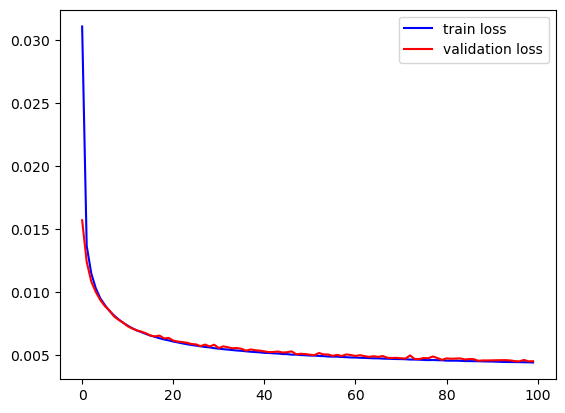

In [9]:
plt.plot(train_losses, 'b', label="train loss")
plt.plot(validation_losses, 'r', label="validation loss")
plt.legend(loc="best")
plt.show()

In [10]:
# nema overfitta
np.argmin(validation_losses)

96

In [25]:
model = model.to('cpu')
test_loader_preview = torch.utils.data.DataLoader(test_dataset, batch_size=6, shuffle=True)
preview_iterator = iter(test_loader_preview)

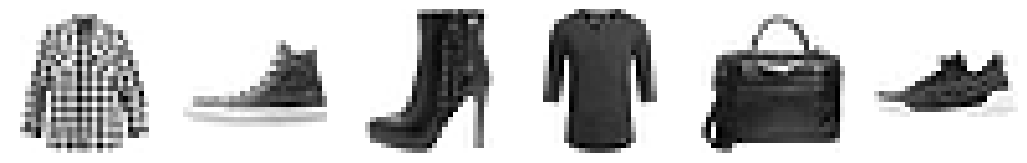

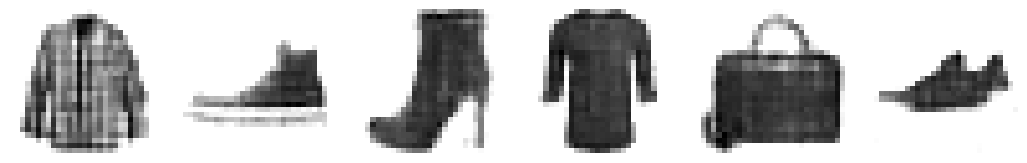

In [27]:
inputs, classes = next(preview_iterator)

def display_image(image, index):
	plt.subplot(1, 6, index)
	plt.axis('off')
	plt.imshow(1 - image, cmap='gray')

plt.figure(figsize=(13, 7))
for i, image in enumerate(inputs):
	display_image(image[0], i+1)
plt.show()

plt.figure(figsize=(13, 7))
for i, image in enumerate(inputs):
	outputs = model(image)
	outputs = outputs.view(28, 28).detach().numpy()
	display_image(outputs, i+1)
plt.show()